## Sampler Type Test
A quick example to test / demonstrate numpyro's sampling methods for a simple case

In [17]:
import jax
import jax.numpy as jnp
import numpyro
import numpy as np
from chainconsumer import ChainConsumer
import matplotlib.pylab as plt

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
numpyro.set_host_device_count(1)
jax.config.update('jax_platform_name', 'cpu')

Generate some trig data. The phase shift / amplitude should have some degeneracy, and we've set the time values to give really bad aliasing

In [18]:
N = 10
w_true = 1
emag = 0.01
X = np.linspace(0,np.pi*(N-1), N )
Y = np.cos(w_true*X)
E = (np.random.poisson(lam=1, size=N)+1) * emag
Y += np.random.randn(N) * E

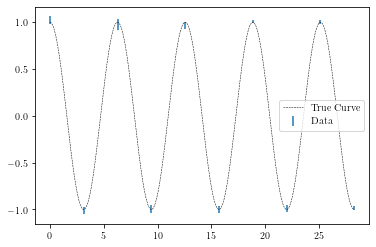

In [19]:
Xplot = np.linspace(0,np.pi*(N-1), N*100 )
Yplot = np.cos(w_true*Xplot)

plt.errorbar(X, Y, E*1.96, fmt='none', label = "Data")
plt.plot(Xplot,Yplot,'--',lw=0.5, label="True Curve", c='k')
plt.legend(loc='best')
plt.show()

Create a numpyro model to fit this data and run an MCMC chain

In [23]:
def model(X,E,Y=None):
    A = 1
    w = numpyro.sample('w',numpyro.distributions.Uniform(0, 4))
    phi = numpyro.sample('phi',numpyro.distributions.Uniform(-np.pi, np.pi))
    
    with numpyro.plate('data',len(X)):
        ypred = A*jnp.cos(w * (X-phi))
        numpyro.sample('y', numpyro.distributions.Normal(ypred, E), obs=Y)

print("Starting Chain")
sampler = numpyro.infer.MCMC(
        numpyro.infer.NUTS(model),
        num_warmup=400,
        num_samples=400,
        num_chains=20,
        progress_bar=False,
        chain_method = 'sequential',
    )

sampler.run(jax.random.PRNGKey(0), X=X, Y=Y, E=E)
print("Chain Finished")

Starting Chain
Chain Finished


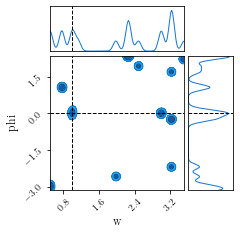

In [24]:
#Do a chain
output = sampler.get_samples()
c = ChainConsumer()
c.add_chain([output['w'], output['phi']], parameters=['w','phi'])
c.plotter.plot(truth=[w_true,0])
plt.show()